Structured Query Language (SQL) oftenly used for data ETL, is essential for data analytics. Other than tools which are specifically designed for SQL developer, SQL is often used in quering and pulling data from DB to Python shell for further analysis (generating Pandas or Spark tables). Libraries like BigQuery, sqlite3, cx_Oracle allow one to apply SQL seamlessly in Python shell. 
This notebook is going to focus on using SQL to analyze customer behavior and segment customers based on statistical models.

# Objective
For retails who provide both online and in-store services, customers can visit store/online for 'window shopping', if interested then quote for price or try things on, if satisfied then purchase. Thus visit, quote and purchase activities are weighted accordingly. Also, understand customer's channel preference and activities could be important for future marketing strategies and budget allocation. 
This analysis developed scores for measuring customer’s channel usages, digital engagement and activity level, created badges for segmenting customers by behavior patterns.


### Attributes
- Attributes used in this analysis are: Customer's store/online visit, store/online quotes, store/online purchase records. 

- Attributes created for analysis are:

Total channel score = 0.2*Visit + 0.3* Quote + 0.5* Purchase
(Weights are determined by activity frequency, 15 visits leads to 10 quotes leads to 6 purchase)

Digital Engagement = Total Digital score/ (Total Digital+Branch Score)

Channel Percentile = percentile rank along all population in each channel

Activity Badge = Activity with highest Channel percentile

# DB connection

### Table information
- Visit Table: Table contains cust_id, mth_id, visit_records
- Quote Table: Table contains cust_id, mth_id, quote_records (ask for price, trying things, etc)
- Purchase Table: Table contains cust_id, mth_id, purchase records

In [ ]:
# connect to oracle database
user_schema=input("Username:")
ora_pass = getpass("Password:")
connect_string = 'oracle://'+user_schema+':'
+ora_pass+'@(DESCRIPTION = (ADDRESS = (PROTOCOL = X)(HOST = X)(PORT = X))(CONNECT_DATA =(SERVER = X)(SERVICE_NAME = X)))'
engine = create_engine(connect_string)
del connect_string, ora_pass

# verify connection and view names of tables in your space
table_list = engine.table_names()
table_list

# table to bring from oracle
table_name='X'
table_schema='X'
table = Table(table_name, MetaData(bind=None), schema=table_schema, autoload=True, autoload_with=engine)

# table columns check
table.columns.keys()
#day_id is one of the columns

# fetch data from oracle and store as pandas dataframe
query = "select * from table"
# or limit to certain columns 
query = select([column(c) for c in table.columns.keys() if c != ['exlucde columns']]).select_from(table)
# or limit to certain value 
query = query.where(table.columns.day_id==20200101)

# execute sql query and generate pandas table
df = pd.DataFrame(engine.execute(query).fetchall(), columns=query.columns.keys())

As this note is about SQL, below will focus on the part 'select * from table' for defining the query

In [ ]:
with score as (
    select v.cust_id, v.mth_id,  
    v.digital_visit, q.digital_quote, p.digital_purchase,     
    (nvl(v.digital_visit,0)*0.2+nvl(q.digital_quote,0)*0.3+nvl(p.digital_purchase,0)*0.5) as digital_score,
    v.store_visit, q.store_quote, p.store_purchase,     
    (nvl(v.store_visit,0)*0.2+nvl(q.store_quote,0)*0.3+nvl(p.store_purchase,0)*0.5) as store_score
from visit v
left join quote q on v.cust_id=q.cust_id and v.mth_id=q.mth_id
left join purchase p on v.cust_id=p.cust_id and v.mth_id=p.mth_id),
tot_score as (
    select s.*, digital_score+store_score as tot_score, 
    case when digital_score+store_score= 0 then 0 
    else round(nvl(digital_score, 0)/(digital_score+store_score), 4) as digital_ratio 
from score s),
tot_score_level as ( 
    select cust_id, mth_id, 
    ntile(3) over (partition by mth_id order by tot_score asc) as tot_score_level 
from ( select * from tot_score where nvl(tot_score,0) <>0 )),
visit_precentile as ( 
    select cust_id, mth_id, 
    percent_rank() over (partition by mth_id order by digital_visit asc) as digital_visit_per_rank,
    percent_rank() over (partition by mth_id order by branch_visit asc) as branch_visit_per_rank
from (select * from tot_score where nvl(digital_visit,0)+nvl(branch_visit,0) <>0)),
quote_precentile as ( 
    select cust_id, mth_id, 
    percent_rank() over (partition by mth_id order by digital_quote asc) as digital_quote_per_rank,
    percent_rank() over (partition by mth_id order by branch_quote asc) as branch_quote_per_rank
from (select * from tot_score where nvl(digital_quote,0)+nvl(branch_quote,0) <>0)),\
purchase_precentile as ( 
    select cust_id, mth_id, 
    percent_rank() over (partition by mth_id order by digital_purchase asc) as digital_purchase_per_rank,
    percent_rank() over (partition by mth_id order by branch_purchase asc) as branch_purchase_per_rank 
from (select * from tot_score where nvl(digital_purchase,0)+nvl(branch_purchase,0) <>0)),
most_active as ( 
    select cust_id, mth_id,
    case when nvl(tot_score, 0 )=0 then 'Dormant'
         when nvl(digital_purchase + branch_purchase, 0)>0 then 'Purchase'
         when nvl(digital_quote + branch_quote, 0)>0 then 'Quote'
         when nvl(digital_visit + branch_visit, 0)>0 then 'Visit'
         end) as active_badge
from tot_score
select s.*, l.tot_score_level, v.digital_visit_per_rank, v.branch_visit_per_rank, 
q.digital_quote_per_rank, q.branch_quote_per_rank, 
p.digital_purchase_per_rank, p.branch_quote_per_rank,
a.active_badge,
greatest(v.digital_visit_per_rank, v.branch_visit_per_rank, q.digital_quote_per_rank, q.branch_quote_per_rank, p.digital_purchase_per_rank, p.branch_quote_per_rank)
 as highest_active_rank
from tot_score 
left join tot_score_level l on s.cust_id=l.cust_id and s.mth_id=l.mth_id
left join visit_precentile v on s.cust_id=v.cust_id and s.mth_id=v.mth_id
left join quote_precentile q on s.cust_id=q.cust_id and s.mth_id=q.mth_id
left join purchase_precentile p on s.cust_id=p.cust_id and s.mth_id=p.mth_id
left join most_active a on s.cust_id=a.cust_id and s.mth_id=a.mth_id
#---create table f_beh_seg as select * from above

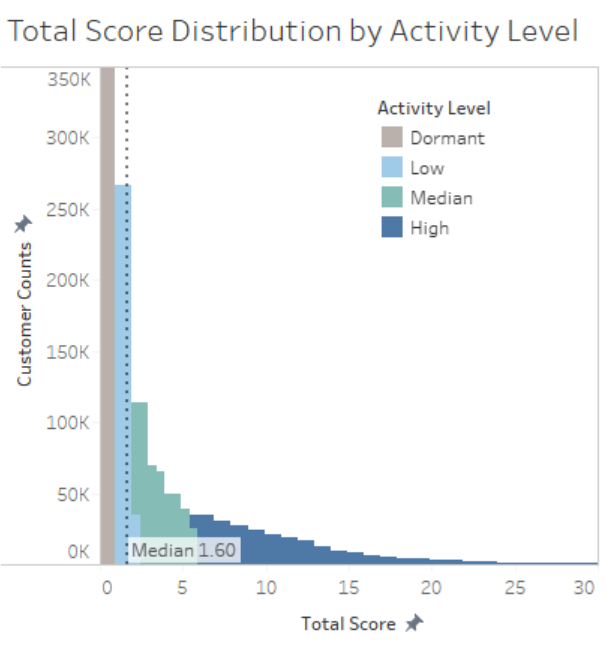

In [1]:
from IPython import display 
display.Image("/kaggle/input/tot-hist/tot score hist.PNG")

Total Score Distribution by Activity Level

Customer total score ranges from 0 (dormant) to 30 (high activity), it follows reversed J-shape distribution, with median at 1.6 and very slow decay after 5. 
Total Score sitribution histogram indicates dormant customers had the highest frequency, and as the score increased, frequency reduced. 

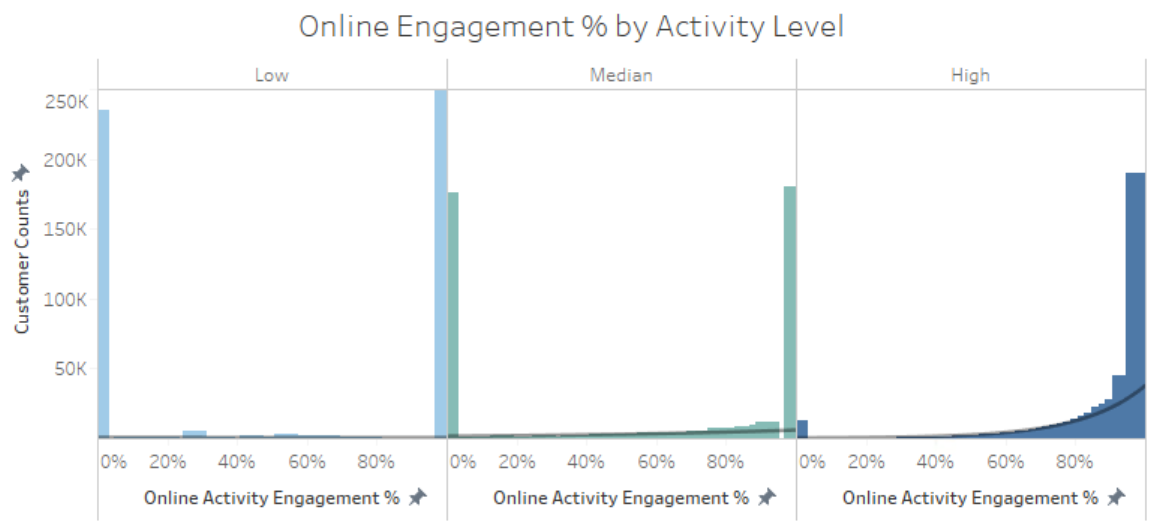

In [2]:
from IPython import display 
display.Image("/kaggle/input/eng-hist/online eng per hist.PNG")

Online engagement percentage by Activity Level

Customer with low activity tends to have polarized (either all in store or online) shopping channel preference. While customer with high activity tends to have higher digital engagement and more continuous online activity engagment precentage distribution.

In [ ]:
select * from (
    select mth_id, active_badge, count(*) as counts 
    from f_beh_seg group by mth_id, active_badge
) pivot (sum (counts) for active_badge in ('Dormant', 'Visit', 'Quote', 'Purchase'))
order by mth_id

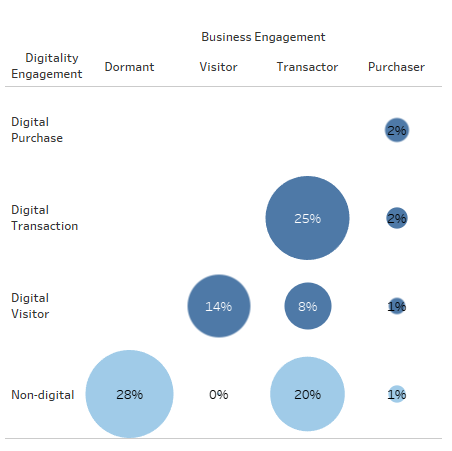

In [3]:
from IPython import display 
display.Image("/kaggle/input/seg-bubble/bubble.PNG")

Business engagement chart:
The bubbles represent the customer's behavior and channel preference. A customer is assigned to a certain bubble based on two dimenstions: his highest hieararchy activity overall with the merchant (columns), and his highest hieararchy activitiy online with the merchant (row). And the bubble shape is corresponding to the number of customers (same as precentage over total population) in each segment. 

For the retail store in this analysis, it's at the tipping point of digitization, with pillar-shaped customer segmentation distribution where all bubbles roughly the same size within each column. 

The ideal fully digitalized chart would have top bubble bigger than the bottom bubbles ( inverted pyramid shape) indicating more activities, especially high hieararchy activity like purchase are done online. 

To achieve digital stage, sending out digital coupons and launching online offers could increase the purchase done digitally as well as increase the total digital traffic. 